In [128]:
import os
import sys
from pathlib import Path
sys.path.append(os.path.dirname(os.path.abspath(Path.cwd())))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, make_scorer
# from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.metrics import plot_confusion_matrix
from scipy import stats
import joblib
import shap
import seaborn as sns


## Load the Dataset

We will load the basic stats dataset from user 1 that we create in the analysis.ipynb notebook, and split the dataset into the train set and the test set. Since out dataset is very imbalance, we will be using SMOTE to peform oversampling on the data.

In [129]:
# load the dataset to a pandas df
data = pd.read_csv("../data/train_data/basic_stats/subject_1.csv")
data.head()

,min_x,max_x,mean_x,std_x,range_x,min_y,max_y,mean_y,std_y,range_y,min_z,max_z,mean_z,std_z,range_z,activity
0,1940,1986,1961.088462,7.673593,46,2365,2396,2377.584615,5.437301,31,2086,2143,2115.726923,11.339209,57,1
1,1925,1999,1956.119231,12.374358,74,2340,2409,2379.503846,9.438890,69,2062,2168,2106.846154,18.925973,106,1
2,1919,1999,1953.280769,12.488837,80,2340,2409,2380.869231,9.430001,69,2062,2168,2101.476923,17.485666,106,1
3,1919,1977,1959.707692,10.208972,58,2368,2394,2379.800000,5.014881,26,2077,2138,2107.876923,10.598328,61,1
4,1941,1980,1964.134615,5.983339,39,2369,2390,2378.407692,3.633172,21,2086,2135,2113.100000,6.042130,49,1


In [130]:
# transform the dataset to numpy arrays
X = data.loc[:, data.columns != 'activity']
y = data['activity']
# initialize SMOTE object for oversampling
sm = SMOTE(random_state=42)
# split the dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)
# fix the imbalance issue in the train dataset
X_train, y_train = sm.fit_resample(X, y)

## Set up a BaseLine model

We will be using a Linear Classifier as our baseline model.

In [131]:
# Initialize the regresstion
reg = linear_model.LogisticRegression(solver='lbfgs', max_iter=1000)
#scale the data first
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# fit the model
reg.fit(X_scaled, y_train)
y_pred = reg.predict(X_test_scaled)
# Print out the report
# print(classification_report(y_train, reg.predict(X_scaled)))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.99      1.00      0.99        74
           2       0.33      1.00      0.50         2
           3       0.23      0.77      0.35        22
           4       0.98      0.82      0.89        62
           5       0.75      1.00      0.86         6
           6       0.29      0.80      0.42         5
           7       0.96      0.67      0.79       194

    accuracy                           0.78       365
   macro avg       0.65      0.87      0.69       365
weighted avg       0.91      0.78      0.82       365



Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


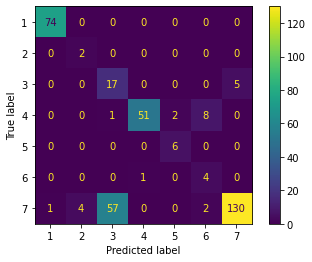

In [132]:
# plot confusion matrix
plot_confusion_matrix(reg, X_test_scaled, y_test) 
plt.show()

The Logistic Regression Classifier was able to predict accurately 92% of the sequence's labels. It was able to seperate activities 1, 3, and 7 quite successfully, but did poorly on other activities. We will try out several more classifiers and hopefully we'll get a better result than the baseline model.

## Support Vector Machine Classifier

In this section, we will build a SVM model, and test its efficiency in classifying different activities in our dataset:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        74
           2       0.50      1.00      0.67         2
           3       0.20      0.95      0.33        22
           4       0.98      0.85      0.91        62
           5       0.75      1.00      0.86         6
           6       0.45      1.00      0.62         5
           7       0.99      0.56      0.72       194

    accuracy                           0.74       365
   macro avg       0.70      0.91      0.73       365
weighted avg       0.93      0.74      0.79       365



Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


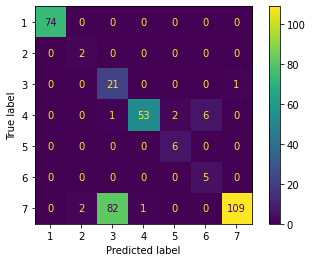

In [133]:
# initialize a SVM model
svc = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# fit the model on the train dataset
svc.fit(X_train, y_train)
# predict the test dataset
y_pred = svc.predict(X_test)
# Print out the report
# print(classification_report(y_train, reg.predict(X_scaled)))
print(classification_report(y_test, y_pred))
# plot confusion matrix
plot_confusion_matrix(svc, X_test, y_test) 
plt.show()

The SVM Classifier performs quite poorly compared to the baseline model. We can observe that the models have difficulty in seperating between activities 3 and 7. Let's switch to tree-based models to see if there's any improvements.

## Tree-based Classifier

In this section, we will try to fit a tree-based classification model on our dataset to see if we can outperform the baseline model. First, we will start with the random forest model:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        74
           2       1.00      1.00      1.00         2
           3       0.73      1.00      0.85        22
           4       1.00      0.98      0.99        62
           5       1.00      1.00      1.00         6
           6       0.83      1.00      0.91         5
           7       1.00      0.96      0.98       194

    accuracy                           0.98       365
   macro avg       0.94      0.99      0.96       365
weighted avg       0.98      0.98      0.98       365



Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


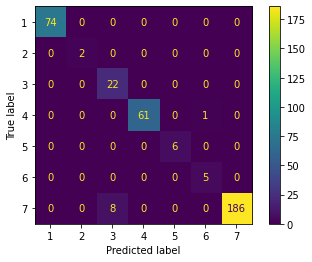

In [134]:
# initialize a RF model
rf = RandomForestClassifier(max_depth=10, random_state=5)
# fit the model on the train dataset
rf.fit(X_train, y_train)
# predict the test dataset
y_pred = rf.predict(X_test)
# Print out the report
# print(classification_report(y_train, reg.predict(X_scaled)))
print(classification_report(y_test, y_pred))
# plot confusion matrix
plot_confusion_matrix(rf, X_test, y_test) 
plt.show()

We can see that there's big improvements in the accuracy anf f1 score, especially this model was able to classify between activity 3 and 6 much better than the baseline model. However, we still want to see if we can increase this improvement further. Next, let's try the XGBoost model, a well-known classifier known for being good at problems like this.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        74
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        62
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00       194

    accuracy                           1.00       365
   macro avg       1.00      1.00      1.00       365
weighted avg       1.00      1.00      1.00       365



Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


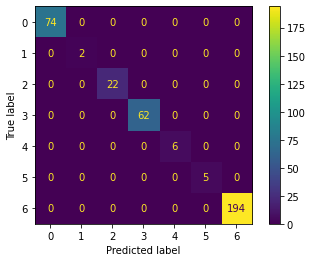

In [135]:
# initialize XGBoost classifier
xgb = XGBClassifier()
# transform the y_train and Y-test class values to start from 0 instead of 1
y_transformed_train = [i - 1 for i in y_train]
y_transformed_test = [i - 1 for i in y_test]
# fit the model
xgb.fit(X_train, y_transformed_train)
# predict the test dataset
y_pred = xgb.predict(X_test)
# print out the report
print(classification_report(y_transformed_test, y_pred))
# draw the confusion matrix
plot_confusion_matrix(xgb, X_test, y_transformed_test) 
plt.show()

The XGBoost model was able to predict accurately 100% of the test cases. Now, we want to save our model so we can use it again in the future.

In [136]:
joblib.dump(reg, "../models/reg_basic.sav")
joblib.dump(svc, "../models/svc_basic.sav")
joblib.dump(rf, "../models/rf_basic.sav")
joblib.dump(xgb, "../models/xgb_basic.sav")


['../models/xgb_basic.sav']

## Interpreting the model

Since the tree-based model has a significantly better performance than the regression model and the svc, we want to see what parameters play the most important role in the prediction. To understand the model decision making process, let's use the Sharpley values to check the internal process of the model:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


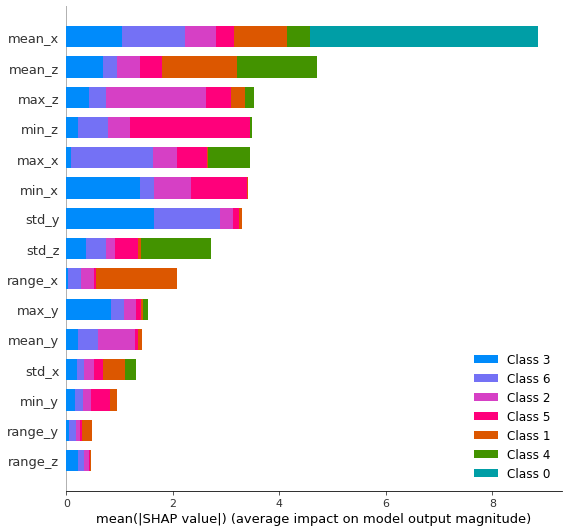

In [137]:
# load the explainer
explainer = shap.TreeExplainer(xgb)
# get the shap values for the test dataset
shap_values = explainer.shap_values(X_test)
# plot the shap values
shap.summary_plot(shap_values, X_test)

The graph above plots features significance that the xgb model used to predict different activities. According to the plot, we can observe that:
- For activity 1, the most significant feature is mean_x
- For activity 2, the most significant features are range_x and mean_z
- For activity 3, the most significant feature is max_z
- For activity 4, the most significant features are std_y and mean_x
- For activity 5, the most significant features are std_z and mean_z
- For activity 6, the most significant feature is min_z
- For activity 7, the most significant features are max_x and std_y  

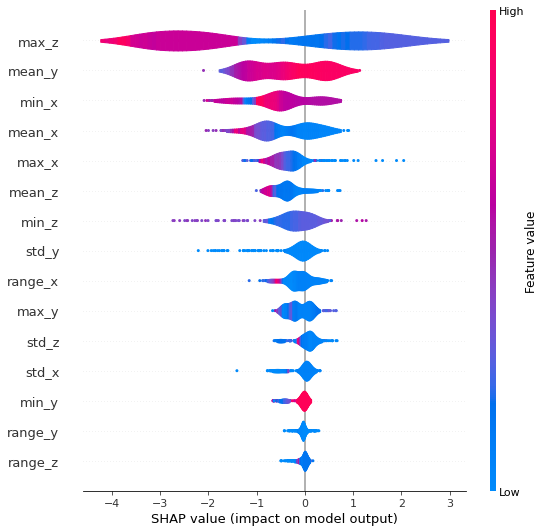

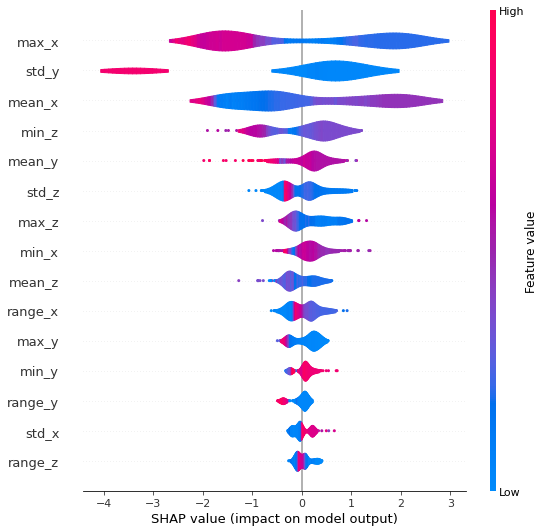

In [138]:

# summary for activity 1
# shap.summary_plot(shap_values[0], X_test, plot_type="violin")
# summary for activity 2
# shap.summary_plot(shap_values[1], X_test, plot_type="violin")
# summary for activity 3
shap.summary_plot(shap_values[2], X_test, plot_type="violin")
# summary for activity 4
# shap.summary_plot(shap_values[3], X_test, plot_type="violin")
# summary for activity 5
# shap.summary_plot(shap_values[4], X_test, plot_type="violin")
# summary for activity 6
# shap.summary_plot(shap_values[5], X_test, plot_type="violin")
# summary for activity 7
shap.summary_plot(shap_values[6], X_test, plot_type="violin")

The plots above show the individual summary plot for the sharpley values of activity 3 and 7. We want to perform A/B testing to see if there is significant statistical evidence for parameter significance between the two classes.

In [139]:
def two_sided_t_test(activity1: int, activity2: int, feature: str):
    activity1_df = data[data['activity'] == activity1][feature]
    activity2_df = data[data['activity'] == activity2][feature]
    t_statistic, p_value = stats.ttest_ind(activity1_df, activity2_df)

    # get color red and green 
    OKRED = '\x1b[31m'
    OKGREEN = '\033[92m'
    ENDC = '\033[0m'

    if p_value < 0.05:
        print(f"{feature} is {OKGREEN} significantly{ENDC} different between activity {activity1} and activity {activity2}")
    else:
        print(f"{feature} is {OKRED}not significantly{ENDC} different between activity {activity1} and activity {activity2}")
    print(f"test feature: {feature} t-test: t = {t_statistic}, p = {p_value}")
    
# perform 2-sample t-test to check if the difference in max_z between activity 3 and 7
two_sided_t_test(3, 7, "max_z")
# perform 2-sample t-test to check if the difference in mean_y between activity 3 and 7
two_sided_t_test(3, 7, "mean_y")
# perform 2-sample t-test to check if the difference in max_x between activity 3 and 7
two_sided_t_test(3, 7, "max_x")
# perform 2-sample t-test to check if the difference in std_y between activity 3 and 7
two_sided_t_test(3, 7, "std_y")


max_z is not significantly different between activity 3 and activity 7
test feature: max_z t-test: t = -1.3481916512971965, p = 0.17802428240416338
mean_y is not significantly different between activity 3 and activity 7
test feature: mean_y t-test: t = 1.1509876007481117, p = 0.25012263697530884
max_x is  significantly different between activity 3 and activity 7
test feature: max_x t-test: t = -3.1098733940236776, p = 0.0019461121848763406
std_y is  significantly different between activity 3 and activity 7
test feature: std_y t-test: t = -2.0498766668179687, p = 0.04074121440578915


As we can see, the mean of feature max_x and std_y is significantly different between activity 3 and 7. To confirm our finding, we can plot the histogram of the two variables between the two activities:

<AxesSubplot:xlabel='max_x', ylabel='Density'>

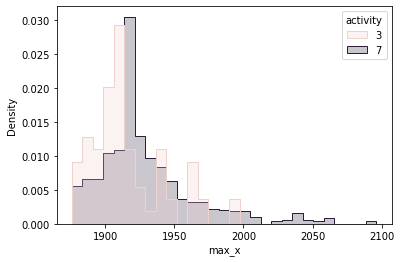

In [143]:
# prepare the data for plotting
his_df = pd.DataFrame(columns=['activity', 'std_y', 'max_x'])
his_df['activity'] = [3 for i in range(len(data[data['activity'] == 3]))] + [7 for i in range(len(data[data['activity'] == 7]))]
his_df['std_y'] = list(data[data['activity'] == 3]['std_y']) + list(data[data['activity'] == 7]['std_y'])
his_df['max_x'] = list(data[data['activity'] == 3]['max_x']) + list(data[data['activity'] == 7]['max_x'])

sns.histplot(
    his_df, x="max_x", hue="activity", element="step",
    stat="density", common_norm=False,
)